<a href="https://colab.research.google.com/github/vibhuverma17/XGB_DEEP_DIVE/blob/main/Research_3_Parkinsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost pandas scikit-learn
!pip install kaggle
# !kaggle competitions download -c allstate-claims-severity
!mkdir Data

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, recall_score, precision_score
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [ ]:
# Load the data
# test = pd.read_csv('/content/Data/test.csv')
train = pd.read_csv('/content/Data/parkinsons_updrs.data')


# Display the first few rows of the training data
print("All Data:")
# print(train.head())

print(train.shape)

train.drop('subject#', axis=1, inplace=True)
train.drop('test_time', axis=1, inplace=True)
train.drop('total_UPDRS', axis=1, inplace=True)

X=train.drop('motor_UPDRS', axis=1)
y=train[['motor_UPDRS']]

# Replace positive and negative infinity with NaN across the DataFrame
X = X.replace([np.inf, -np.inf], np.nan)

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3)

All Data:
(5875, 22)


#### TUNED PARAMETERS

In XGBoost, not all hyperparameters are typically tuned. Some of them have default values that are often left unchanged unless there’s a need to optimize them for a specific dataset. Here's a breakdown of the commonly tuned hyperparameters from the dictionary you provided and those that are typically left as defaults:

### Hyperparameters to Tune:
1. **`learning_rate`** (`eta`): Controls the step size during the optimization process.
   - Typical range: `0.01` to `0.3`.

2. **`n_estimators`**: The number of trees to build.
   - Typical range: `50` to `500` (or more depending on the dataset).

3. **`max_depth`**: Maximum depth of a tree, controls overfitting.
   - Typical range: `3` to `10`.

4. **`min_child_weight`**: Minimum sum of instance weight (hessian) needed in a child.
   - Typical range: `1` to `10`.

5. **`subsample`**: The fraction of observations to be randomly sampled for each tree.
   - Typical range: `0.5` to `1`.

6. **`colsample_bytree`**: Fraction of features to be randomly sampled for each tree.
   - Typical range: `0.5` to `1`.

7. **`min_split_loss`**: Minimum loss reduction required to make a further partition on a leaf node.
   - Typical range: `0` to `5`.

8. **`reg_alpha`** (L1 regularization term): Encourages sparsity (i.e., more feature elimination).
   - Typical range: `0` to `1`.

9. **`reg_lambda`** (L2 regularization term): Controls overfitting by adding a penalty.
   - Typical range: `0` to `1`.

### Hyperparameters Less Commonly Tuned (Defaults Usually Work Well):
1. **`booster`**: Specifies which booster to use, either `gbtree` or `gblinear`.
   - Usually left as `gbtree`.

2. **`objective`**: Objective function for the problem (e.g., `reg:squarederror` for regression).
   - Usually set based on the problem type.

3. **`silent`**: Controls verbosity of output (deprecated in newer versions, replaced by `verbosity`).
   - Set to `0` (silent) or `1` (verbose).

4. **`base_score`**: The initial prediction score of all instances, typically the mean of the target variable.
   - Usually left as the default.

5. **`scale_pos_weight`**: Balances positive and negative weights for imbalanced datasets.
   - Typically tuned for imbalanced classification problems, not relevant for regression.

### LEARNING RATE

In [ ]:
# Define the range of learning rates to test
learning_rate_start = 0.01
learning_rate_end = 1
num_learning_rates = 100  # Number of learning rates to generate
learning_rates = np.linspace(learning_rate_start, learning_rate_end, num_learning_rates)

# Prepare a DataFrame to store all gain data and performance metrics
all_gain_data = pd.DataFrame()
all_metrics_data = pd.DataFrame()

# Assuming X_train and y_train are already defined
# Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)

# Loop over each learning rate
for lr in learning_rates:
    # Define hyperparameters for the model
    hyperparameters = {
        'booster': 'gbtree',
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': lr,
        'min_child_weight': 1,
        'gamma': 0,
        'subsample': 1,
        'colsample_bytree': 1,
        'colsample_bylevel': 1,
        'colsample_bynode': 1,
        'reg_alpha': 0,  # L1 regularization
        'reg_lambda': 1,  # L2 regularization
        'scale_pos_weight': 1,
        'base_score': 0.5,
        'random_state': 0,
        'objective': 'reg:squarederror',  # For regression
        'tree_method': 'auto',
        'n_jobs': -1,
        'verbosity': 1,
        'max_delta_step': 0,
        'seed': None,
        'eval_metric': None,  # Default depends on objective
        'early_stopping_rounds': None,
        'grow_policy': 'depthwise',
        'monotone_constraints': None,
        'interaction_constraints': None,
        'importance_type': 'gain',  # Feature importance type
        'gpu_id': -1,  # Defaults to CPU
        'predictor': 'auto',  # Use CPU or GPU predictor automatically
    }


    # Train the model using the DMatrix
    model = xgb.train(params=hyperparameters, dtrain=dtrain)

    # Extract tree structure data into a DataFrame
    tree_df = model.trees_to_dataframe()

    tree_df['is_root_split'] = tree_df['Node'] == 0

    # Convert hyperparameters to a string to store them in the DataFrame
    hyperparameters_str = str(hyperparameters)

    # Check if the 'Default' column exists
    if 'Default' in tree_df.columns:
        # Extract relevant columns, including default values and hyperparameters
        gain_data = tree_df[['Tree', 'Node', 'Feature', 'Gain', 'Default', 'is_root_split']]
    else:
        # If 'Default' does not exist, exclude it
        gain_data = tree_df[['Tree', 'Node', 'Feature', 'Gain', 'is_root_split']]

    # Add hyperparameters and learning rate to the gain_data DataFrame
    gain_data['Hyperparameters'] = hyperparameters_str

    # Concatenate the gain_data for this learning rate to the overall gain DataFrame
    all_gain_data = pd.concat([all_gain_data, gain_data], ignore_index=True)

    # Make predictions for training and testing sets
    y_pred_train = model.predict(dtrain)

    # Create DMatrix for test data
    dtest = xgb.DMatrix(X_test, enable_categorical=True)

    # Make predictions on the test set
    y_pred_test = model.predict(dtest)

    # Calculate metrics for training data
    train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)

    # Calculate metrics for testing data
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    # Store all metrics in a DataFrame for this iteration
    metrics_data = pd.DataFrame({
        'Learning_Rate': [lr],
        'Train_MAPE': [train_mape],
        'Train_MSE': [train_mse],
        'Train_RMSE': [train_rmse],
        'Train_MAE': [train_mae],
        'Train_R2': [train_r2],
        'Test_MAPE': [test_mape],
        'Test_MSE': [test_mse],
        'Test_RMSE': [test_rmse],
        'Test_MAE': [test_mae],
        'Test_R2': [test_r2],
        'Hyperparameters': [hyperparameters_str]
    })

    # Concatenate metrics data to the overall DataFrame
    all_metrics_data = pd.concat([all_metrics_data, metrics_data], ignore_index=True)

# At the end, you may want to save all_gain_data and all_metrics_data for further analysis

In [ ]:
# Display the first few rows of the metrics DataFrame
print("\nMetrics Data for different learning rates:")
all_metrics_data.head()


Metrics Data for different learning rates:


,Learning_Rate,Train_MAPE,Train_MSE,Train_RMSE,Train_MAE,Train_R2,Test_MAPE,Test_MSE,Test_RMSE,Test_MAE,Test_R2,Hyperparameters
0,0.01,0.873571,412.832758,20.318286,18.827776,-5.269501,0.872987,412.217503,20.303140,18.793572,-5.189373,"{'booster': 'gbtree', 'n_estimators': 100, 'ma..."
1,0.02,0.784624,341.398937,18.476984,17.021634,-4.184668,0.783669,340.830506,18.461595,16.986417,-4.117510,"{'booster': 'gbtree', 'n_estimators': 100, 'ma..."
2,0.03,0.703834,282.054077,16.794466,15.372767,-3.283424,0.702298,281.301952,16.772059,15.331253,-3.223700,"{'booster': 'gbtree', 'n_estimators': 100, 'ma..."
3,0.04,0.630474,232.875689,15.260265,13.869528,-2.536576,0.628564,232.074071,15.233978,13.825459,-2.484551,"{'booster': 'gbtree', 'n_estimators': 100, 'ma..."
4,0.05,0.563818,192.422225,13.871634,12.500466,-1.922228,0.561183,191.487235,13.837891,12.447597,-1.875147,"{'booster': 'gbtree', 'n_estimators': 100, 'ma..."


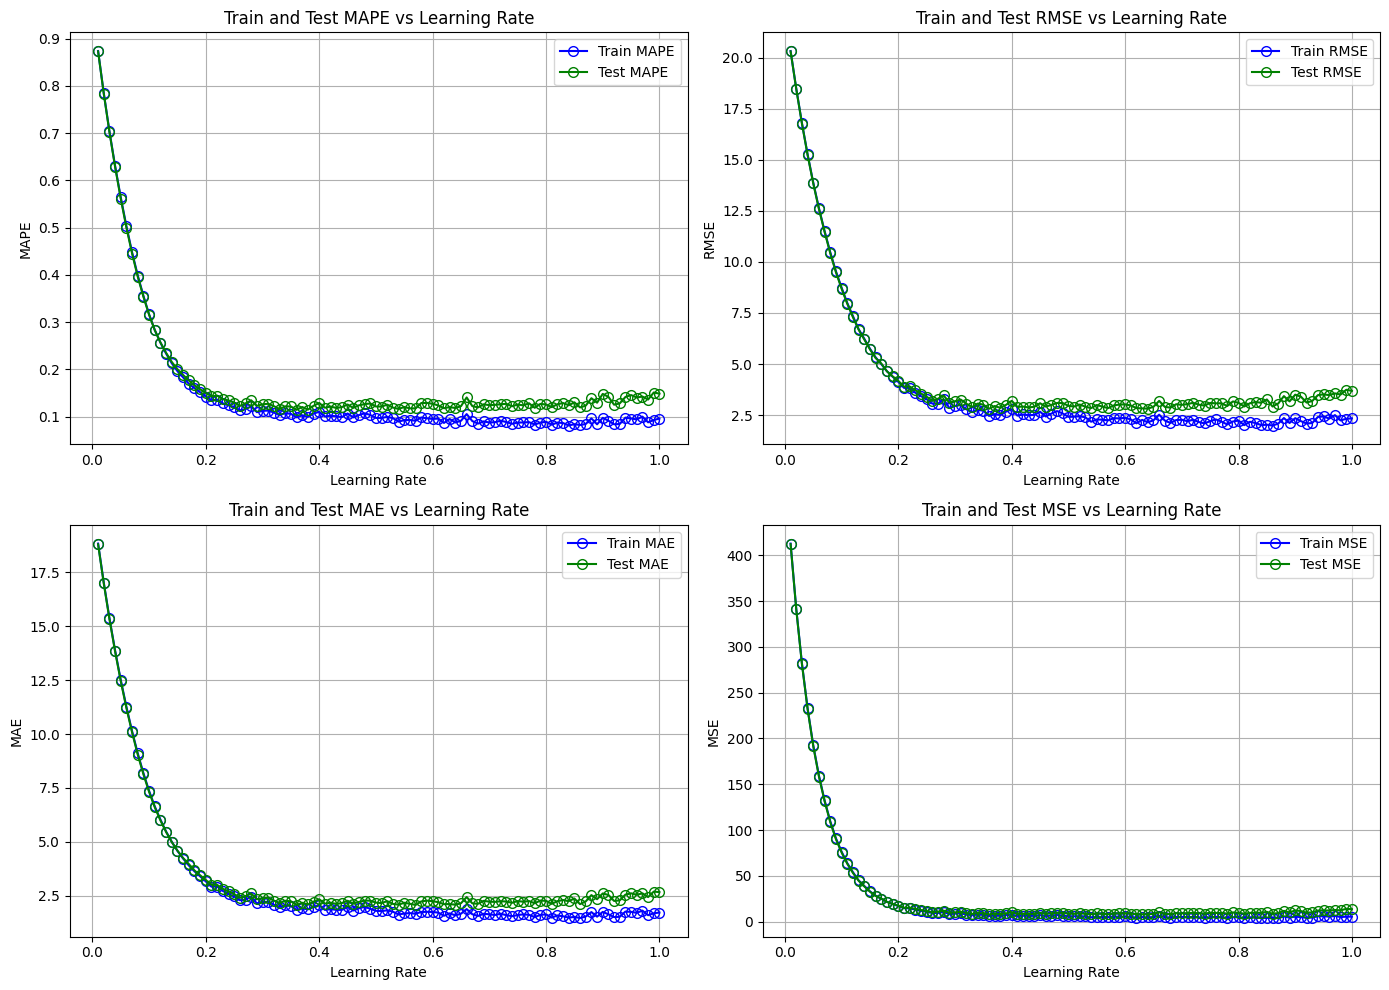

In [ ]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define colors and marker size
train_color = 'blue'
test_color = 'green'
marker_size = 7  # Adjust this value for finer dots

# Plot 1: Train and Test MAPE vs Learning Rate
axes[0, 0].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Train_MAPE'], label='Train MAPE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[0, 0].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Test_MAPE'], label='Test MAPE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[0, 0].set_xlabel('Learning Rate')
axes[0, 0].set_ylabel('MAPE')
axes[0, 0].set_title('Train and Test MAPE vs Learning Rate')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Train and Test RMSE vs Learning Rate
axes[0, 1].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Train_RMSE'], label='Train RMSE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[0, 1].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Test_RMSE'], label='Test RMSE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[0, 1].set_xlabel('Learning Rate')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('Train and Test RMSE vs Learning Rate')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Train and Test MAE vs Learning Rate
axes[1, 0].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Train_MAE'], label='Train MAE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[1, 0].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Test_MAE'], label='Test MAE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[1, 0].set_xlabel('Learning Rate')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_title('Train and Test MAE vs Learning Rate')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Train and Test MSE vs Learning Rate
axes[1, 1].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Train_MSE'], label='Train MSE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[1, 1].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Test_MSE'], label='Test MSE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[1, 1].set_xlabel('Learning Rate')
axes[1, 1].set_ylabel('MSE')
axes[1, 1].set_title('Train and Test MSE vs Learning Rate')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# Convert the 'Hyperparameters' column from string to dictionary
all_gain_data['Hyperparameters'] = all_gain_data['Hyperparameters'].apply(ast.literal_eval)
all_gain_data['Learning_Rate_Value'] = all_gain_data['Hyperparameters'].apply(lambda x: x['learning_rate'])

all_gain_data.head()

,Tree,Node,Feature,Gain,is_root_split,Hyperparameters,Learning_Rate_Value
0,0,0,age,47429.87500,True,"{'booster': 'gbtree', 'n_estimators': 100, 'ma...",0.01
1,0,1,age,22762.75000,False,"{'booster': 'gbtree', 'n_estimators': 100, 'ma...",0.01
2,0,2,age,7123.62500,False,"{'booster': 'gbtree', 'n_estimators': 100, 'ma...",0.01
3,0,3,age,7174.56250,False,"{'booster': 'gbtree', 'n_estimators': 100, 'ma...",0.01
4,0,4,Shimmer,1226.16211,False,"{'booster': 'gbtree', 'n_estimators': 100, 'ma...",0.01


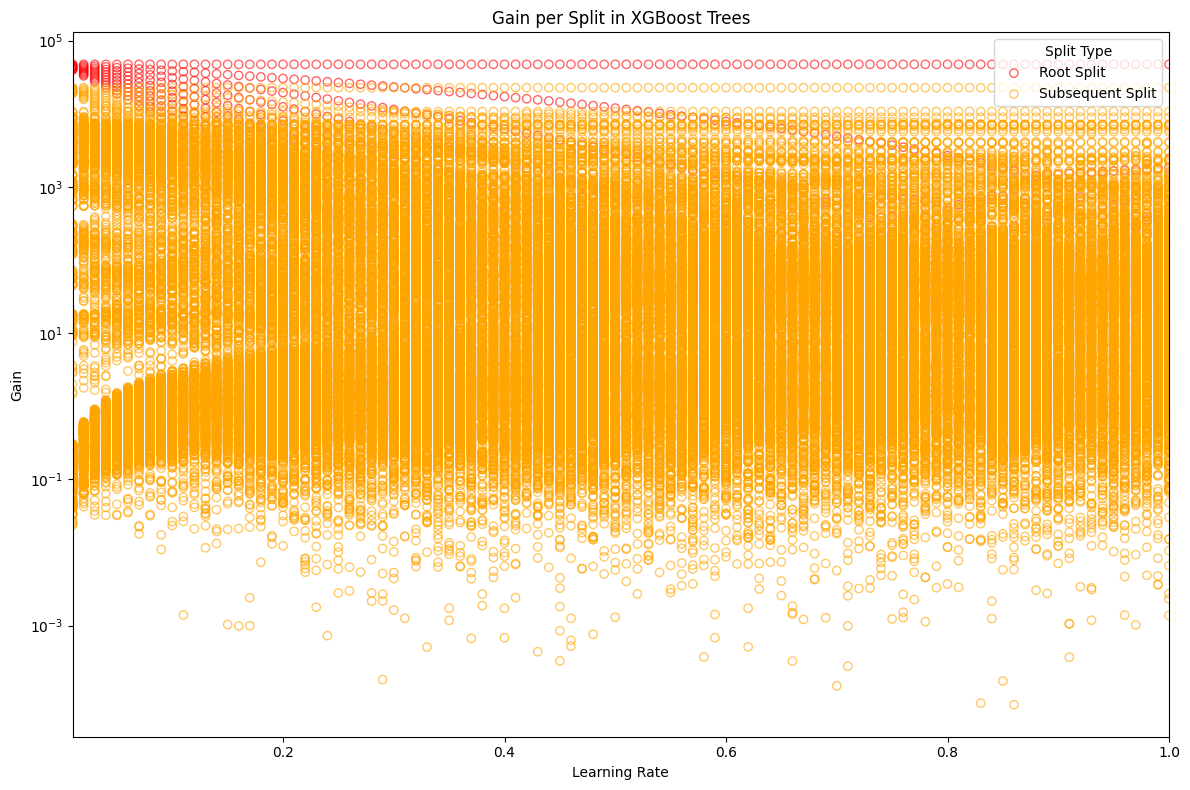

In [ ]:
# Define the feature for the X-axis
feature = 'Learning_Rate_Value'

# Create the plot
plt.figure(figsize=(12, 8))

# Plotting for root splits (is_root_split=True)
sns.scatterplot(
    data=all_gain_data[all_gain_data['is_root_split']],
    x=feature,
    y='Gain',
    # size='Gain',
    color='red',                   # Red edge color for root splits
    sizes=(20, 500),
    edgecolor='red',
    facecolors='none',             # Hollow inside
    linewidth=1,
    alpha=0.6
)

# Plotting for non-root splits (is_root_split=False)
sns.scatterplot(
    data=all_gain_data[~all_gain_data['is_root_split']],
    x=feature,
    y='Gain',
    # size='Gain',
    color='orange',                # Orange edge color for subsequent splits
    sizes=(20, 500),
    edgecolor='orange',
    facecolors='none',             # Hollow inside
    linewidth=1,
    alpha=0.6
)

# Set plot labels and title
plt.xlim(all_gain_data[feature].min(), all_gain_data[feature].max())
plt.title('Gain per Split in XGBoost Trees')
plt.xlabel('Learning Rate')
plt.ylabel('Gain')

# Adjust the legend title and labels manually
plt.legend(['Root Split', 'Subsequent Split'], title='Split Type', loc='upper right')

# Set the Y-axis to a logarithmic scale
plt.yscale('log')

# Remove the grid lines
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()


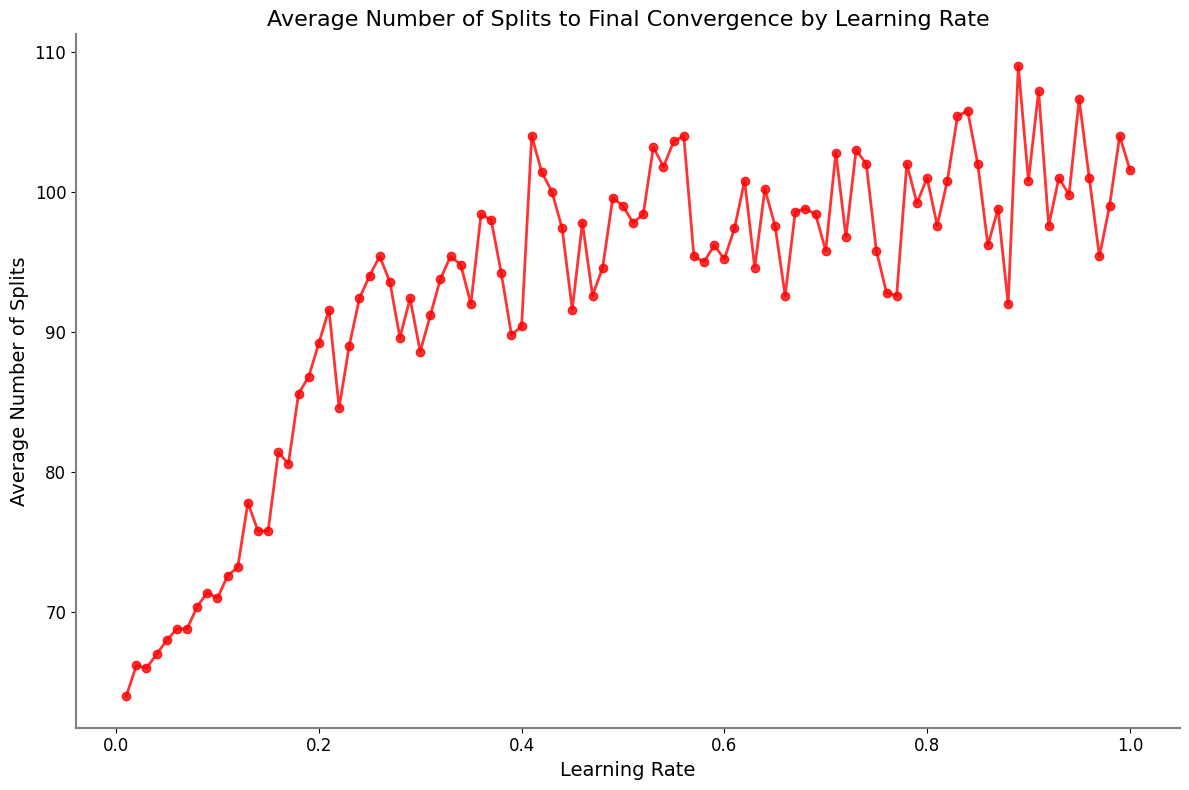

In [ ]:
# Count the number of nodes (splits) per tree for each learning rate
total_splits = all_gain_data.groupby(['Learning_Rate_Value', 'Tree'])['Node'].count().reset_index(name='Total_Splits')

# Calculate the average number of splits for each learning rate
average_splits = total_splits.groupby('Learning_Rate_Value')['Total_Splits'].mean().reset_index()

# Create a line chart
plt.figure(figsize=(12, 8))
plt.plot(average_splits['Learning_Rate_Value'], average_splits['Total_Splits'], marker='o', color='red', linestyle='-', alpha=0.8, linewidth=2)

# Set plot labels and title
plt.title('Average Number of Splits to Final Convergence by Learning Rate', fontsize=16)
plt.xlabel('Learning Rate', fontsize=14)
plt.ylabel('Average Number of Splits', fontsize=14)

# Set x-axis ticks to show only at intervals of 0.2
plt.xticks(np.arange(0, max(average_splits['Learning_Rate_Value']) + 0.1, 0.2), fontsize=12)

# Adjust y-ticks
plt.yticks(fontsize=12)

# Customize the appearance
plt.gca().spines['top'].set_visible(False)     # Hide the top spine
plt.gca().spines['right'].set_visible(False)   # Hide the right spine
plt.gca().spines['left'].set_color('gray')     # Set left spine color
plt.gca().spines['bottom'].set_color('gray')    # Set bottom spine color
plt.gca().spines['left'].set_linewidth(1.5)     # Set left spine linewidth
plt.gca().spines['bottom'].set_linewidth(1.5)    # Set bottom spine linewidth

# Remove grid lines
plt.grid(False)

# Display the plot
plt.tight_layout()
plt.show()

### MAX DEPTH

In [ ]:
# Define range for max_depth
max_depth_start = 1
max_depth_end = 50  # High end for the maximum depth range
max_depth_gap = 5   # Increase in steps of 5 for higher values
max_depth_list = list(range(max_depth_start, max_depth_end + 1, max_depth_gap)) + [None]  # None for unrestricted depth

# Initialize DataFrames to store results
all_gain_data = pd.DataFrame()
all_metrics_data = pd.DataFrame()

# Loop over each max_depth value
for max_depth in max_depth_list:
    # Define hyperparameters
    hyperparameters = {
        'booster': 'gbtree',
        'n_estimators': 100,  # Fixed value for n_estimators or can vary as before
        'max_depth': max_depth,
        'learning_rate': 0.1,
        'min_child_weight': 1,
        'gamma': 0,
        'subsample': 1,
        'colsample_bytree': 1,
        'colsample_bylevel': 1,
        'colsample_bynode': 1,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'scale_pos_weight': 1,
        'base_score': 0.5,
        'random_state': 0,
        'objective': 'reg:squarederror',
        'tree_method': 'auto',
        'n_jobs': -1,
        'verbosity': 1,
        'grow_policy': 'depthwise',
        'importance_type': 'gain',
    }

    # Train the model using the DMatrix
    model = xgb.train(params=hyperparameters, dtrain=dtrain)

    # Extract tree structure data into a DataFrame
    tree_df = model.trees_to_dataframe()
    tree_df['is_root_split'] = tree_df['Node'] == 0

    # Convert hyperparameters to a string to store them in the DataFrame
    hyperparameters_str = str(hyperparameters)

    # Check if the 'Default' column exists and set up gain data
    if 'Default' in tree_df.columns:
        gain_data = tree_df[['Tree', 'Node', 'Feature', 'Gain', 'Default', 'is_root_split']]
    else:
        gain_data = tree_df[['Tree', 'Node', 'Feature', 'Gain', 'is_root_split']]

    gain_data['Hyperparameters'] = hyperparameters_str
    all_gain_data = pd.concat([all_gain_data, gain_data], ignore_index=True)

    # Make predictions for training and testing sets
    y_pred_train = model.predict(dtrain)

    dtest = xgb.DMatrix(X_test, enable_categorical=True)
    y_pred_test = model.predict(dtest)

    # Calculate metrics for training data
    train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)

    # Calculate metrics for testing data
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    # Store all metrics in a DataFrame for this iteration
    metrics_data = pd.DataFrame({
        'Max_Depth': [max_depth],
        'Train_MAPE': [train_mape],
        'Train_MSE': [train_mse],
        'Train_RMSE': [train_rmse],
        'Train_MAE': [train_mae],
        'Train_R2': [train_r2],
        'Test_MAPE': [test_mape],
        'Test_MSE': [test_mse],
        'Test_RMSE': [test_rmse],
        'Test_MAE': [test_mae],
        'Test_R2': [test_r2],
        'Hyperparameters': [hyperparameters_str]
    })

    all_metrics_data = pd.concat([all_metrics_data, metrics_data], ignore_index=True)


In [ ]:
# Display the first few rows of the metrics DataFrame
print("\nMetrics Data for different learning rates:")
all_metrics_data.head()


Metrics Data for different learning rates:


,Max_Depth,Train_MAPE,Train_MSE,Train_RMSE,Train_MAE,Train_R2,Test_MAPE,Test_MSE,Test_RMSE,Test_MAE,Test_R2,Hyperparameters
0,1,0.357109,108.167923,10.400381,8.305251,-0.642696,0.353494,107.071731,10.347547,8.212415,-0.607663,"{'booster': 'gbtree', 'n_estimators': 100, 'ma..."
1,6,0.316260,76.295080,8.734706,7.358194,-0.158658,0.315419,75.452990,8.686368,7.312440,-0.132913,"{'booster': 'gbtree', 'n_estimators': 100, 'ma..."
2,11,0.336775,68.453858,8.273685,7.409126,-0.039577,0.334914,69.046445,8.309419,7.384230,-0.036720,"{'booster': 'gbtree', 'n_estimators': 100, 'ma..."
3,16,0.339335,67.445180,8.212501,7.417164,-0.024259,0.337130,68.418175,8.271528,7.396221,-0.027287,"{'booster': 'gbtree', 'n_estimators': 100, 'ma..."
4,21,0.339355,67.443008,8.212369,7.417394,-0.024226,0.337141,68.418751,8.271563,7.396359,-0.027295,"{'booster': 'gbtree', 'n_estimators': 100, 'ma..."


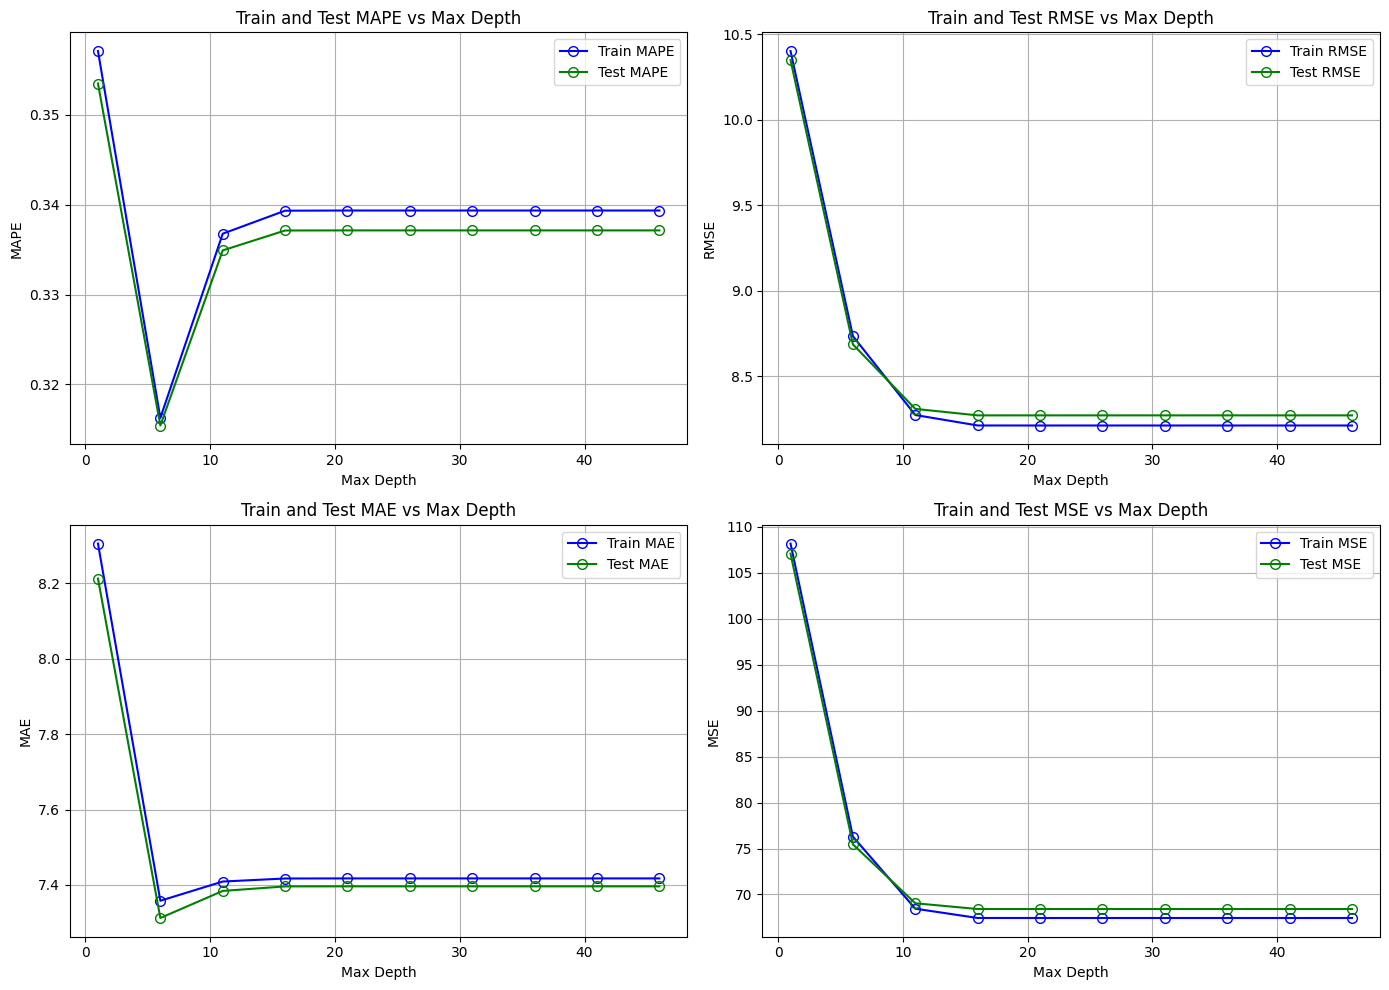

In [ ]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define colors and marker size
train_color = 'blue'
test_color = 'green'
marker_size = 7  # Adjust this value for finer dots

# Plot 1: Train and Test MAPE vs Max Depth
axes[0, 0].plot(all_metrics_data['Max_Depth'], all_metrics_data['Train_MAPE'], label='Train MAPE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[0, 0].plot(all_metrics_data['Max_Depth'], all_metrics_data['Test_MAPE'], label='Test MAPE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[0, 0].set_xlabel('Max Depth')
axes[0, 0].set_ylabel('MAPE')
axes[0, 0].set_title('Train and Test MAPE vs Max Depth')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Train and Test RMSE vs Max Depth
axes[0, 1].plot(all_metrics_data['Max_Depth'], all_metrics_data['Train_RMSE'], label='Train RMSE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[0, 1].plot(all_metrics_data['Max_Depth'], all_metrics_data['Test_RMSE'], label='Test RMSE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[0, 1].set_xlabel('Max Depth')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('Train and Test RMSE vs Max Depth')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Train and Test MAE vs Max Depth
axes[1, 0].plot(all_metrics_data['Max_Depth'], all_metrics_data['Train_MAE'], label='Train MAE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[1, 0].plot(all_metrics_data['Max_Depth'], all_metrics_data['Test_MAE'], label='Test MAE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[1, 0].set_xlabel('Max Depth')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_title('Train and Test MAE vs Max Depth')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Train and Test MSE vs Max Depth
axes[1, 1].plot(all_metrics_data['Max_Depth'], all_metrics_data['Train_MSE'], label='Train MSE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[1, 1].plot(all_metrics_data['Max_Depth'], all_metrics_data['Test_MSE'], label='Test MSE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[1, 1].set_xlabel('Max Depth')
axes[1, 1].set_ylabel('MSE')
axes[1, 1].set_title('Train and Test MSE vs Max Depth')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
# Convert the 'Hyperparameters' column from string to dictionary
all_gain_data['Hyperparameters'] = all_gain_data['Hyperparameters'].apply(ast.literal_eval)
all_gain_data['Max_Depth'] = all_gain_data['Hyperparameters'].apply(lambda x: x['max_depth'])

all_gain_data.head()

,Tree,Node,Feature,Gain,is_root_split,Hyperparameters,Max_Depth
0,0,0,age,47429.875000,True,"{'booster': 'gbtree', 'n_estimators': 100, 'ma...",1.0
1,0,1,Leaf,1.748252,False,"{'booster': 'gbtree', 'n_estimators': 100, 'ma...",1.0
2,0,2,Leaf,2.430717,False,"{'booster': 'gbtree', 'n_estimators': 100, 'ma...",1.0
3,1,0,age,38423.125000,True,"{'booster': 'gbtree', 'n_estimators': 100, 'ma...",1.0
4,1,1,Leaf,1.573510,False,"{'booster': 'gbtree', 'n_estimators': 100, 'ma...",1.0


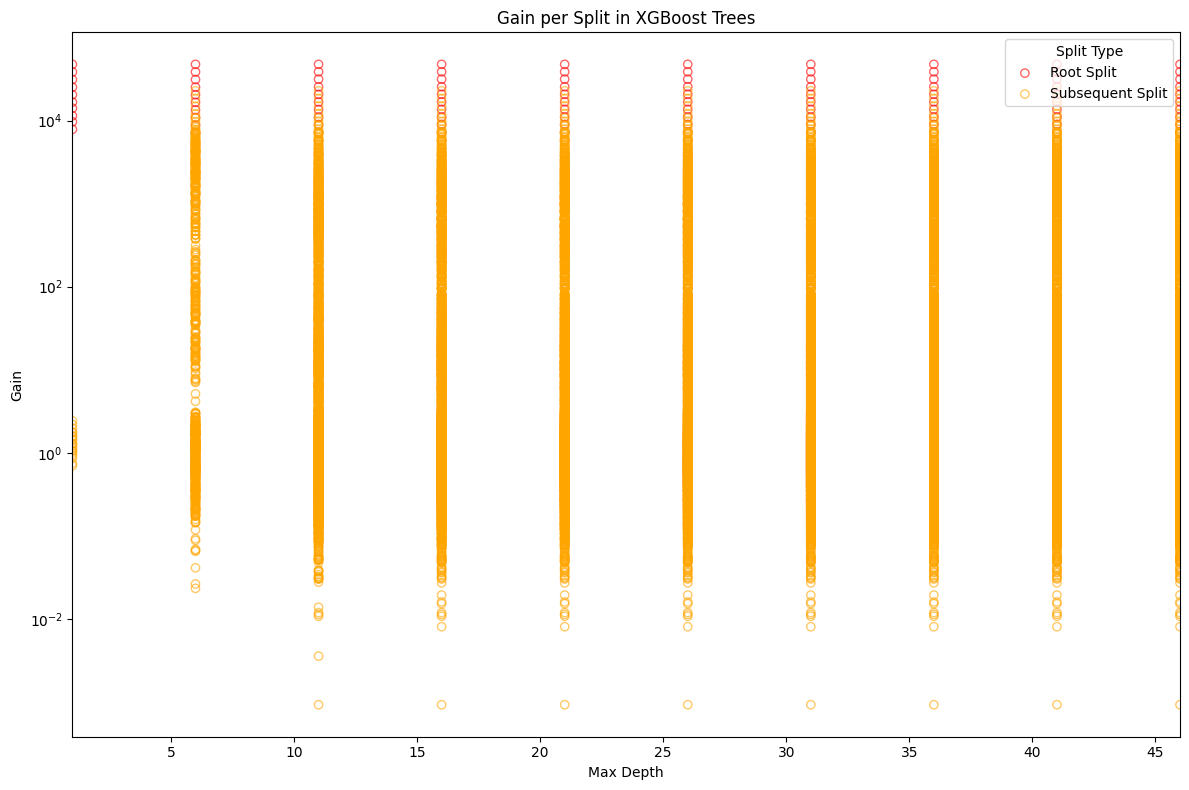

In [ ]:
# Define the feature for the X-axis
feature = 'Max_Depth'

# Create the plot
plt.figure(figsize=(12, 8))

# Plotting for root splits (is_root_split=True)
sns.scatterplot(
    data=all_gain_data[all_gain_data['is_root_split']],
    x=feature,
    y='Gain',
    # size='Gain',
    color='red',                   # Red edge color for root splits
    sizes=(20, 500),
    edgecolor='red',
    facecolors='none',             # Hollow inside
    linewidth=1,
    alpha=0.6
)

# Plotting for non-root splits (is_root_split=False)
sns.scatterplot(
    data=all_gain_data[~all_gain_data['is_root_split']],
    x=feature,
    y='Gain',
    # size='Gain',
    color='orange',                # Orange edge color for subsequent splits
    sizes=(20, 500),
    edgecolor='orange',
    facecolors='none',             # Hollow inside
    linewidth=1,
    alpha=0.6
)

# Set plot labels and title
plt.xlim(all_gain_data[feature].min(), all_gain_data[feature].max())
plt.title('Gain per Split in XGBoost Trees')
plt.xlabel('Max Depth')
plt.ylabel('Gain')

# Adjust the legend title and labels manually
plt.legend(['Root Split', 'Subsequent Split'], title='Split Type', loc='upper right')

# Set the Y-axis to a logarithmic scale
plt.yscale('log')

# Remove the grid lines
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()


### N_ESTIMATORS

In [ ]:
# Convert training and test data to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, enable_categorical=True)

# Define range for num_boost_round (number of boosting rounds or trees)
num_boost_round_list = [1, 5, 10,20,30,40] + list(range(50, 550, 50))   # Adjust range and step as needed

# Initialize DataFrames to store results
all_gain_data = pd.DataFrame()
all_metrics_data = pd.DataFrame()

# Loop over each num_boost_round value
for num_boost_round in num_boost_round_list:
    # Define hyperparameters
    hyperparameters = {
        'booster': 'gbtree',
        'max_depth': 6,  # Adjust as needed
        'learning_rate': 0.1,
        'min_child_weight': 1,
        'gamma': 0,
        'subsample': 1,
        'colsample_bytree': 1,
        'colsample_bylevel': 1,
        'colsample_bynode': 1,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'scale_pos_weight': 1,
        'base_score': 0.5,
        'random_state': 0,
        'objective': 'reg:squarederror',
        'tree_method': 'auto',
        'n_jobs': -1,
        'verbosity': 1,
        'grow_policy': 'depthwise',
        'importance_type': 'gain',
    }

    # Train the model using num_boost_round instead of n_estimators
    model = xgb.train(params=hyperparameters, dtrain=dtrain, num_boost_round=num_boost_round)

    # Extract tree structure data into a DataFrame
    tree_df = model.trees_to_dataframe()
    tree_df['is_root_split'] = tree_df['Node'] == 0

    # Convert hyperparameters to a string to store them in the DataFrame
    hyperparameters_str = str(hyperparameters)

    # Check if the 'Default' column exists and set up gain data
    if 'Default' in tree_df.columns:
        gain_data = tree_df[['Tree', 'Node', 'Feature', 'Gain', 'Default', 'is_root_split']]
    else:
        gain_data = tree_df[['Tree', 'Node', 'Feature', 'Gain', 'is_root_split']]

    gain_data['Hyperparameters'] = hyperparameters_str
    gain_data['Num_Boost_Round'] = num_boost_round
    all_gain_data = pd.concat([all_gain_data, gain_data], ignore_index=True)

    # Make predictions for training and testing sets
    y_pred_train = model.predict(dtrain)
    dtest = xgb.DMatrix(X_test, enable_categorical=True)
    y_pred_test = model.predict(dtest)

    # Calculate metrics for training data
    train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)

    # Calculate metrics for testing data
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    # Store all metrics in a DataFrame for this iteration
    metrics_data = pd.DataFrame({
        'Num_Boost_Round': [num_boost_round],
        'Train_MAPE': [train_mape],
        'Train_MSE': [train_mse],
        'Train_RMSE': [train_rmse],
        'Train_MAE': [train_mae],
        'Train_R2': [train_r2],
        'Test_MAPE': [test_mape],
        'Test_MSE': [test_mse],
        'Test_RMSE': [test_rmse],
        'Test_MAE': [test_mae],
        'Test_R2': [test_r2],
        'Hyperparameters': [hyperparameters_str]
    })

    all_metrics_data = pd.concat([all_metrics_data, metrics_data], ignore_index=True)


In [ ]:
# Display the first few rows of the metrics DataFrame
print("\nMetrics Data for different learning rates:")
all_metrics_data.head()


Metrics Data for different learning rates:


,Num_Boost_Round,Train_MAPE,Train_MSE,Train_RMSE,Train_MAE,Train_R2,Test_MAPE,Test_MSE,Test_RMSE,Test_MAE,Test_R2,Hyperparameters
0,1,0.868763,409.279378,20.230654,18.736915,-5.215537,0.867749,408.295839,20.206332,18.694328,-5.130490,"{'booster': 'gbtree', 'max_depth': 6, 'learnin..."
1,5,0.555066,187.990849,13.710975,12.329978,-1.854930,0.552978,187.222566,13.682930,12.284396,-1.811114,"{'booster': 'gbtree', 'max_depth': 6, 'learnin..."
2,10,0.316260,76.295080,8.734706,7.358194,-0.158658,0.315419,75.452990,8.686368,7.312440,-0.132913,"{'booster': 'gbtree', 'max_depth': 6, 'learnin..."
3,20,0.150161,19.043138,4.363844,3.379285,0.710801,0.157274,19.227896,4.384963,3.438641,0.711297,"{'booster': 'gbtree', 'max_depth': 6, 'learnin..."
4,30,0.111036,9.226411,3.037501,2.270626,0.859883,0.122765,10.513140,3.242397,2.416207,0.842147,"{'booster': 'gbtree', 'max_depth': 6, 'learnin..."


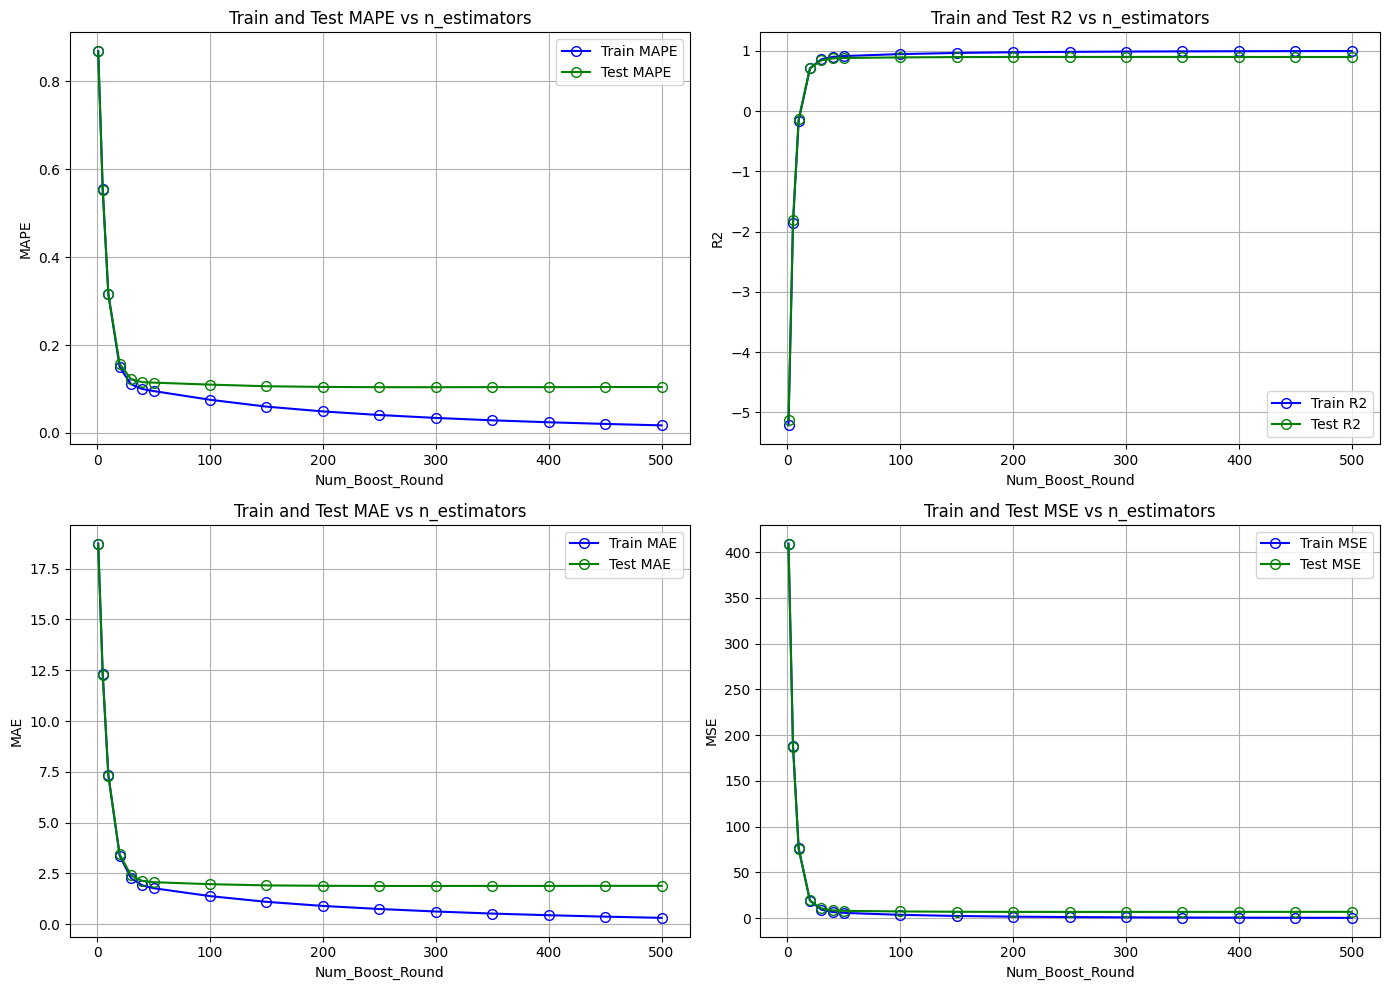

In [ ]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define colors and marker size
train_color = 'blue'
test_color = 'green'
marker_size = 7  # Adjust this value for finer dots

# Plot 1: Train and Test MAPE vs n_estimators
axes[0, 0].plot(all_metrics_data['Num_Boost_Round'], all_metrics_data['Train_MAPE'], label='Train MAPE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[0, 0].plot(all_metrics_data['Num_Boost_Round'], all_metrics_data['Test_MAPE'], label='Test MAPE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[0, 0].set_xlabel('Num_Boost_Round')
axes[0, 0].set_ylabel('MAPE')
axes[0, 0].set_title('Train and Test MAPE vs n_estimators')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Train and Test RMSE vs n_estimators
axes[0, 1].plot(all_metrics_data['Num_Boost_Round'], all_metrics_data['Train_R2'], label='Train R2',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[0, 1].plot(all_metrics_data['Num_Boost_Round'], all_metrics_data['Test_R2'], label='Test R2',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[0, 1].set_xlabel('Num_Boost_Round')
axes[0, 1].set_ylabel('R2')
axes[0, 1].set_title('Train and Test R2 vs n_estimators')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Train and Test MAE vs n_estimators
axes[1, 0].plot(all_metrics_data['Num_Boost_Round'], all_metrics_data['Train_MAE'], label='Train MAE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[1, 0].plot(all_metrics_data['Num_Boost_Round'], all_metrics_data['Test_MAE'], label='Test MAE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[1, 0].set_xlabel('Num_Boost_Round')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_title('Train and Test MAE vs n_estimators')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Train and Test MSE vs n_estimators
axes[1, 1].plot(all_metrics_data['Num_Boost_Round'], all_metrics_data['Train_MSE'], label='Train MSE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[1, 1].plot(all_metrics_data['Num_Boost_Round'], all_metrics_data['Test_MSE'], label='Test MSE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[1, 1].set_xlabel('Num_Boost_Round')
axes[1, 1].set_ylabel('MSE')
axes[1, 1].set_title('Train and Test MSE vs n_estimators')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
all_gain_data.head()

,Tree,Node,Feature,Gain,is_root_split,Hyperparameters,Num_Boost_Round
0,0,0,age,47429.87500,True,"{'booster': 'gbtree', 'max_depth': 6, 'learnin...",1
1,0,1,age,22762.75000,False,"{'booster': 'gbtree', 'max_depth': 6, 'learnin...",1
2,0,2,age,7123.62500,False,"{'booster': 'gbtree', 'max_depth': 6, 'learnin...",1
3,0,3,age,7174.56250,False,"{'booster': 'gbtree', 'max_depth': 6, 'learnin...",1
4,0,4,Shimmer,1226.16211,False,"{'booster': 'gbtree', 'max_depth': 6, 'learnin...",1


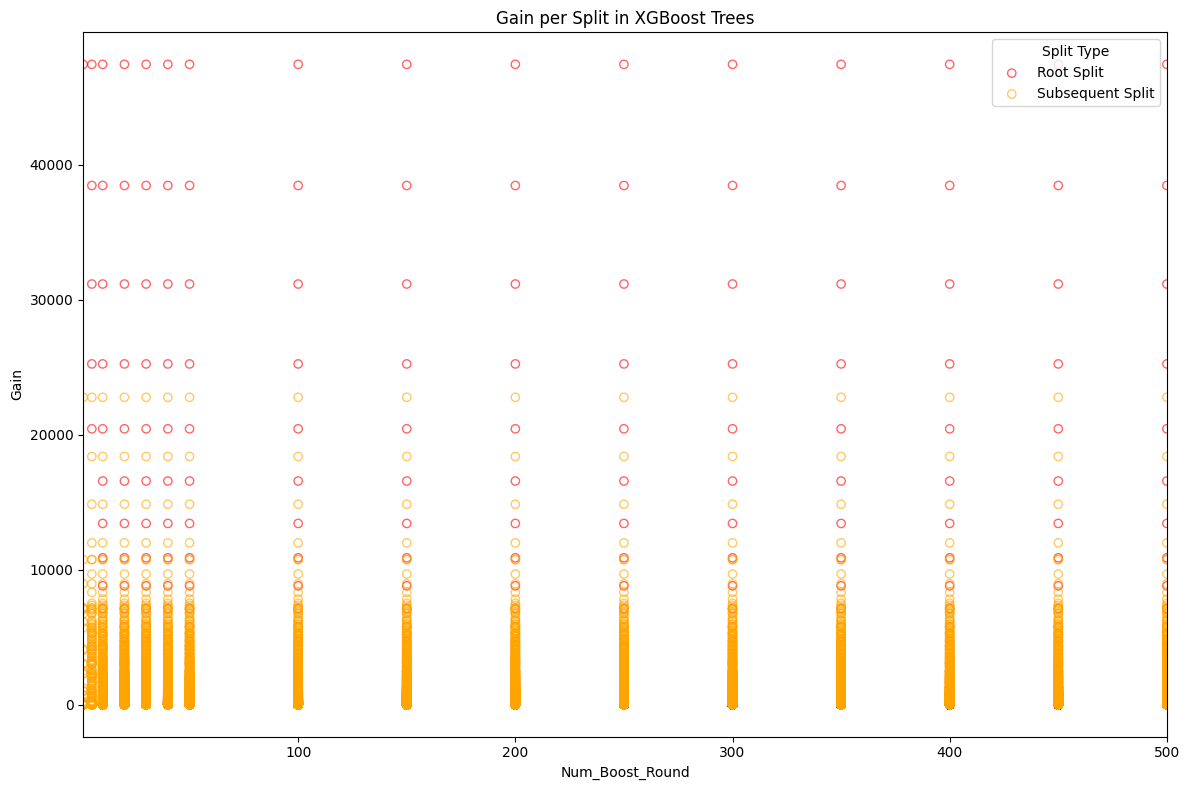

In [ ]:
# Define the feature for the X-axis
feature = 'Num_Boost_Round'

# Create the plot
plt.figure(figsize=(12, 8))

# Plotting for root splits (is_root_split=True)
sns.scatterplot(
    data=all_gain_data[all_gain_data['is_root_split']],
    x=feature,
    y='Gain',
    # size='Gain',
    color='red',                   # Red edge color for root splits
    sizes=(20, 500),
    edgecolor='red',
    facecolors='none',             # Hollow inside
    linewidth=1,
    alpha=0.6
)

# Plotting for non-root splits (is_root_split=False)
sns.scatterplot(
    data=all_gain_data[~all_gain_data['is_root_split']],
    x=feature,
    y='Gain',
    # size='Gain',
    color='orange',                # Orange edge color for subsequent splits
    sizes=(20, 500),
    edgecolor='orange',
    facecolors='none',             # Hollow inside
    linewidth=1,
    alpha=0.6
)

# Set plot labels and title
plt.xlim(all_gain_data[feature].min(), all_gain_data[feature].max())
plt.title('Gain per Split in XGBoost Trees')
plt.xlabel('Num_Boost_Round')
plt.ylabel('Gain')

# Adjust the legend title and labels manually
plt.legend(['Root Split', 'Subsequent Split'], title='Split Type', loc='upper right')

# Set the Y-axis to a logarithmic scale
# plt.yscale('log')

# Remove the grid lines
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()


### MIN CHILD WEIGHT

In [ ]:
# Define the range of min_child_weight values with a step of 0.5
min_child_weight_start = 1
min_child_weight_end = 20
min_child_weight_step = 0.5

# Create the list of min_child_weight values
min_child_weights = np.arange(min_child_weight_start, min_child_weight_end + min_child_weight_step, min_child_weight_step)

# Prepare a DataFrame to store all gain data and performance metrics
all_gain_data = pd.DataFrame()
all_metrics_data = pd.DataFrame()

# Assuming X_train and y_train are already defined
# Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)

# Loop over each min_child_weight value
for min_child_weight in min_child_weights:
    # Define hyperparameters for the model
    hyperparameters = {
        'booster': 'gbtree',
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1,
        'min_child_weight': min_child_weight,  # Set min_child_weight here
        'gamma': 0,  # You can set a fixed gamma value or vary it if needed
        'subsample': 1,
        'colsample_bytree': 1,
        'colsample_bylevel': 1,
        'colsample_bynode': 1,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'scale_pos_weight': 1,
        'base_score': 0.5,
        'random_state': 0,
        'objective': 'reg:squarederror',  # For regression
        'tree_method': 'auto',
        'n_jobs': -1,
        'verbosity': 1,
        'max_delta_step': 0,
        'seed': None,
        'eval_metric': None,
        'early_stopping_rounds': None,
        'grow_policy': 'depthwise',
        'monotone_constraints': None,
        'interaction_constraints': None,
        'importance_type': 'gain',
        'gpu_id': -1,
        'predictor': 'auto',
    }

    # Train the model using the DMatrix
    model = xgb.train(params=hyperparameters, dtrain=dtrain)

    # Extract tree structure data into a DataFrame
    tree_df = model.trees_to_dataframe()

    tree_df['is_root_split'] = tree_df['Node'] == 0

    # Convert hyperparameters to a string to store them in the DataFrame
    hyperparameters_str = str(hyperparameters)

    # Check if the 'Default' column exists
    if 'Default' in tree_df.columns:
        # Extract relevant columns, including default values and hyperparameters
        gain_data = tree_df[['Tree', 'Node', 'Feature', 'Gain', 'Default', 'is_root_split']]
    else:
        # If 'Default' does not exist, exclude it
        gain_data = tree_df[['Tree', 'Node', 'Feature', 'Gain', 'is_root_split']]

    # Add hyperparameters and min_child_weight value to the gain_data DataFrame
    gain_data['Hyperparameters'] = hyperparameters_str

    # Concatenate the gain_data for this min_child_weight value to the overall gain DataFrame
    all_gain_data = pd.concat([all_gain_data, gain_data], ignore_index=True)

    # Make predictions for training and testing sets
    y_pred_train = model.predict(dtrain)

    # Create DMatrix for test data
    dtest = xgb.DMatrix(X_test, enable_categorical=True)

    # Make predictions on the test set
    y_pred_test = model.predict(dtest)

    # Calculate metrics for training data
    train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)

    # Calculate metrics for testing data
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    # Store all metrics in a DataFrame for this iteration
    metrics_data = pd.DataFrame({
        'min_child_weight': [min_child_weight],  # Change to min_child_weight
        'Train_MAPE': [train_mape],
        'Train_MSE': [train_mse],
        'Train_RMSE': [train_rmse],
        'Train_MAE': [train_mae],
        'Train_R2': [train_r2],
        'Test_MAPE': [test_mape],
        'Test_MSE': [test_mse],
        'Test_RMSE': [test_rmse],
        'Test_MAE': [test_mae],
        'Test_R2': [test_r2],
        'Hyperparameters': [hyperparameters_str]
    })

    # Concatenate metrics data to the overall DataFrame
    all_metrics_data = pd.concat([all_metrics_data, metrics_data], ignore_index=True)


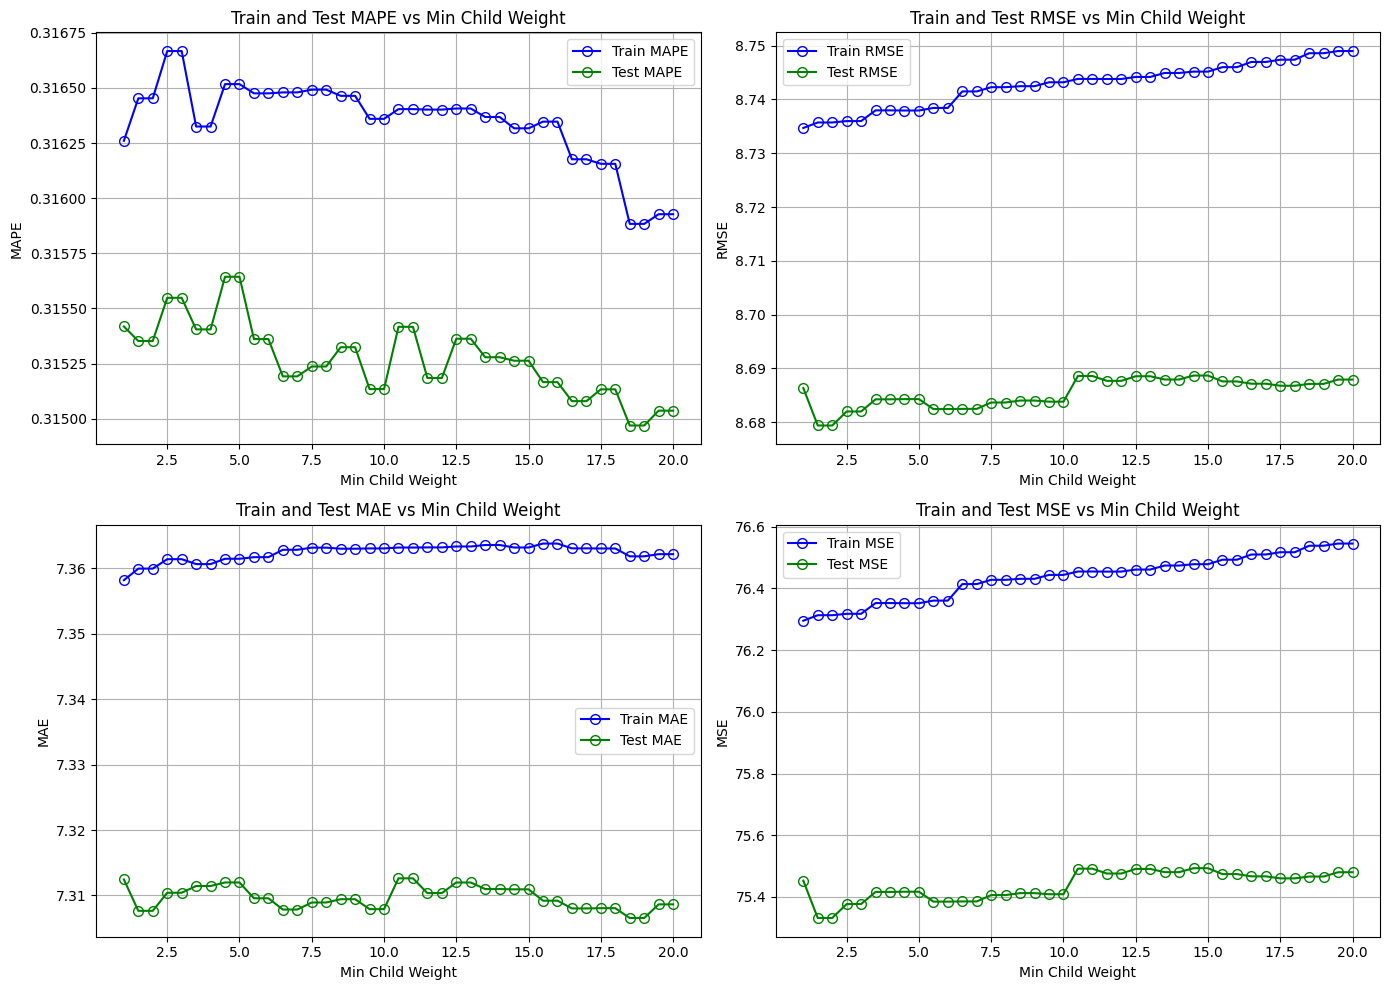

In [ ]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define colors and marker size
train_color = 'blue'
test_color = 'green'
marker_size = 7  # Adjust this value for finer dots

# Plot 1: Train and Test MAPE vs min_child_weight
axes[0, 0].plot(all_metrics_data['min_child_weight'], all_metrics_data['Train_MAPE'], label='Train MAPE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[0, 0].plot(all_metrics_data['min_child_weight'], all_metrics_data['Test_MAPE'], label='Test MAPE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[0, 0].set_xlabel('Min Child Weight')
axes[0, 0].set_ylabel('MAPE')
axes[0, 0].set_title('Train and Test MAPE vs Min Child Weight')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Train and Test RMSE vs min_child_weight
axes[0, 1].plot(all_metrics_data['min_child_weight'], all_metrics_data['Train_RMSE'], label='Train RMSE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[0, 1].plot(all_metrics_data['min_child_weight'], all_metrics_data['Test_RMSE'], label='Test RMSE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[0, 1].set_xlabel('Min Child Weight')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('Train and Test RMSE vs Min Child Weight')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Train and Test MAE vs min_child_weight
axes[1, 0].plot(all_metrics_data['min_child_weight'], all_metrics_data['Train_MAE'], label='Train MAE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[1, 0].plot(all_metrics_data['min_child_weight'], all_metrics_data['Test_MAE'], label='Test MAE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[1, 0].set_xlabel('Min Child Weight')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_title('Train and Test MAE vs Min Child Weight')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Train and Test MSE vs min_child_weight
axes[1, 1].plot(all_metrics_data['min_child_weight'], all_metrics_data['Train_MSE'], label='Train MSE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[1, 1].plot(all_metrics_data['min_child_weight'], all_metrics_data['Test_MSE'], label='Test MSE',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[1, 1].set_xlabel('Min Child Weight')
axes[1, 1].set_ylabel('MSE')
axes[1, 1].set_title('Train and Test MSE vs Min Child Weight')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()